In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Mount Google Drive (Assuming your dataset is in Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the path to your dataset
dataset_path = '/content/drive/My Drive/Alzheimer_Dataset'

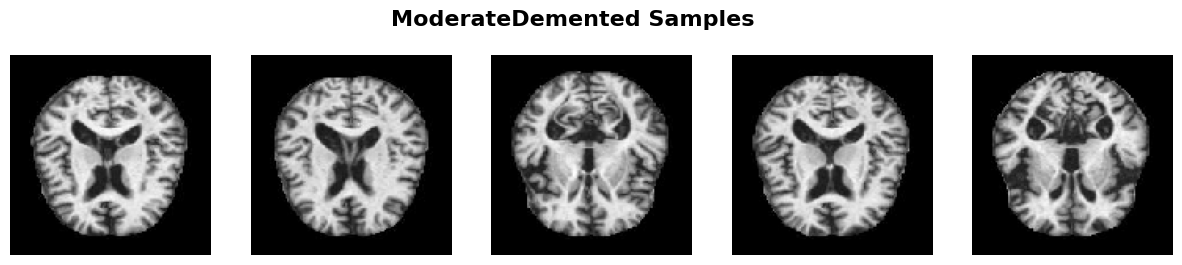

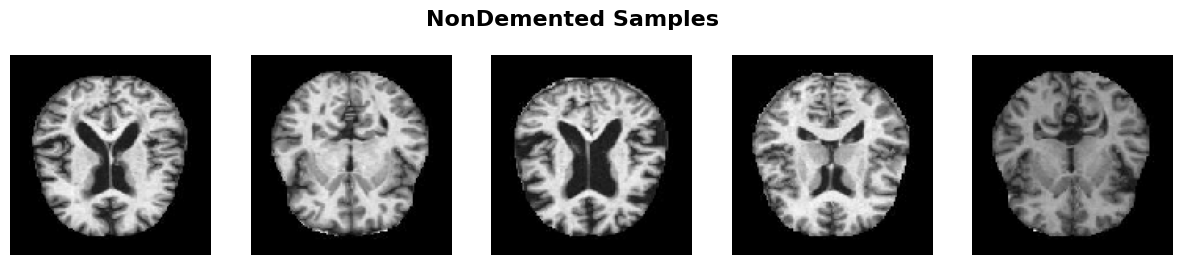

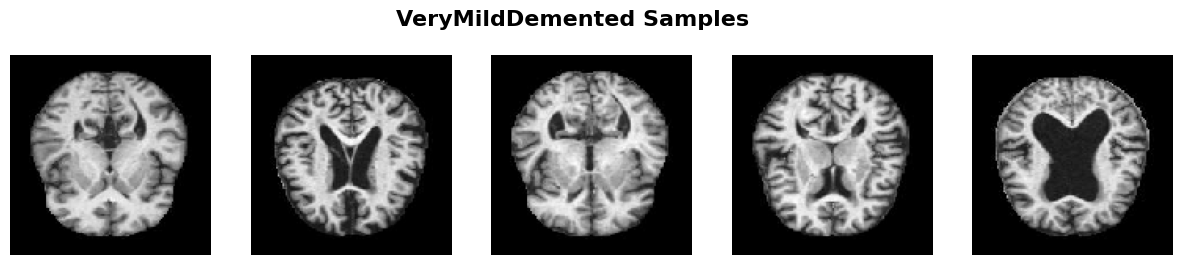

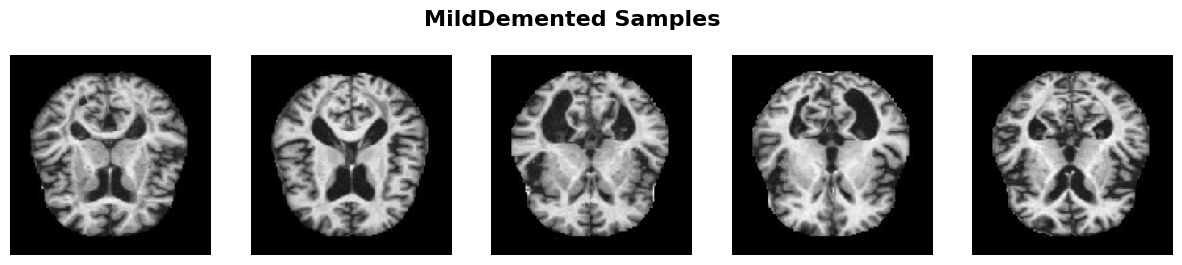

In [4]:
# Display a few images from each class
class_names = os.listdir(os.path.join(dataset_path, 'train'))
num_samples = 5

for class_name in class_names:
    class_path = os.path.join(dataset_path, 'train', class_name)
    image_files = random.sample(os.listdir(class_path), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(f'{class_name} Samples', fontsize=16, fontweight='bold')

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

In [5]:
# Function to load and preprocess the dataset
def load_dataset(batch_size=32, img_size=(128, 128)):
    train_data = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, 'train'),
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42,
        label_mode='categorical'
    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, 'test'),
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False,
        label_mode='categorical'
    )

    return train_data, test_data

In [6]:
# Function to build the CNN model
def build_model(input_shape):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(class_names), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
# Function to train the model
def train_model(model, train_data, val_data, epochs=20):
    checkpoint_filepath = '/content/drive/My Drive/model_checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    callbacks = [model_checkpoint_callback, early_stopping]

    history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

    # Plotting loss and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(history.epoch, history.history['loss'], label='Train Loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(history.epoch, history.history['accuracy'], label='Train Accuracy')
    ax[1].plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

In [8]:
# Function to evaluate the model
def evaluate_model(model, test_data):
    result = model.evaluate(test_data)
    print(f'Test Loss: {result[0]}, Test Accuracy: {result[1]}')

In [9]:
# Function to generate and display the confusion matrix
def display_confusion_matrix(model, test_data):
    predictions = []
    true_labels = []

    for images, labels in test_data:
        predictions.extend(np.argmax(model.predict(images), axis=1))
        true_labels.extend(np.argmax(labels.numpy(), axis=1))

    class_labels = [class_name for class_name in class_names]
    cm = confusion_matrix(true_labels, predictions)
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [10]:
# Function to save the model to Google Drive
def save_model_to_drive(model):
    model.save('/content/drive/My Drive/alzheimer_model.h5')
    print('Model saved to Google Drive.')

In [11]:
# Load and preprocess the dataset
batch_size = 32
img_size = (128, 128)
train_data, test_data = load_dataset(batch_size=batch_size, img_size=img_size)

Found 1728 files belonging to 4 classes.
Found 1236 files belonging to 4 classes.


In [12]:
# Build the model
input_shape = (img_size[0], img_size[1], 3)
model = build_model(input_shape)

Epoch 1/20
54/54 [==============================] - ETA: 0s - loss: 2.6043 - accuracy: 0.4641 
Epoch 1: val_accuracy improved from -inf to 0.33565, saving model to /content/drive/My Drive/model_checkpoint
54/54 [==============================] - 267s 4s/step - loss: 2.6043 - accuracy: 0.4641 - val_loss: 4.5739 - val_accuracy: 0.3356
Epoch 2/20
53/54 [============================>.] - ETA: 0s - loss: 0.6354 - accuracy: 0.7370
Epoch 2: val_accuracy improved from 0.33565 to 0.41146, saving model to /content/drive/My Drive/model_checkpoint
54/54 [==============================] - 7s 127ms/step - loss: 0.6309 - accuracy: 0.7384 - val_loss: 1.3962 - val_accuracy: 0.4115
Epoch 3/20
53/54 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8933
Epoch 3: val_accuracy improved from 0.41146 to 0.84433, saving model to /content/drive/My Drive/model_checkpoint
54/54 [==============================] - 10s 181ms/step - loss: 0.3069 - accuracy: 0.8941 - val_loss: 0.4502 - val_accur

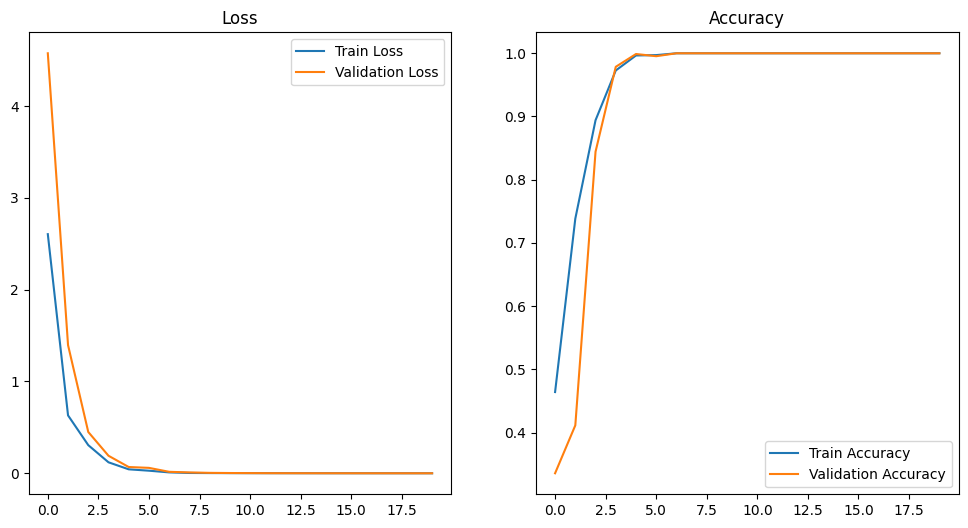

In [13]:
# Train the model
train_model(model, train_data, val_data=train_data, epochs=20)

In [14]:
# Evaluate the model
evaluate_model(model, test_data)

39/39 [==============================] - 263s 7s/step - loss: 1.4245 - accuracy: 0.6335
Test Loss: 1.4244959354400635, Test Accuracy: 0.6334951519966125


In [18]:
import pandas as pd

# Display metrics and confusion matrix
def display_metrics_and_confusion_matrix(model, test_data, class_names):
    # Generate predictions and true labels
    predictions = []
    true_labels = []

    for images, labels in test_data:
        predictions.extend(np.argmax(model.predict(images), axis=1))
        true_labels.extend(np.argmax(labels.numpy(), axis=1))

    # Display classification report
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))

    # Display confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

1/1 [==============================] - 0s 20ms/step
Classification Report:
                  precision    recall  f1-score   support

ModerateDemented       0.65      0.40      0.49       179
     NonDemented       1.00      0.17      0.29        12
VeryMildDemented       0.63      0.82      0.71       597
    MildDemented       0.63      0.49      0.55       448

        accuracy                           0.63      1236
       macro avg       0.73      0.47      0.51      1236
    weighted avg       0.64      0.63      0.62      1236



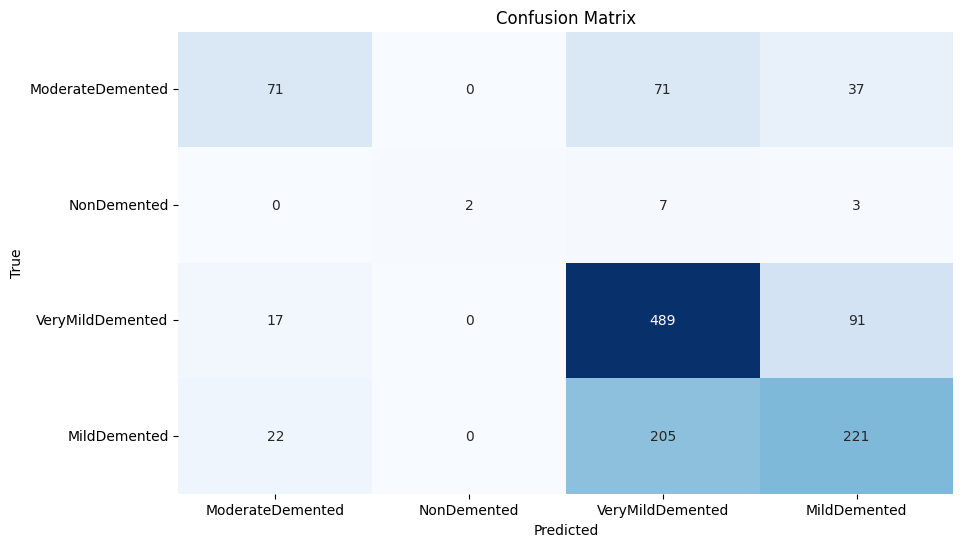

In [19]:
# Display metrics and confusion matrix
display_metrics_and_confusion_matrix(model, test_data, class_names)


In [20]:
model.save('/content/drive/My Drive/AlzheimerCNN_Trained_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
